In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

### Getting Relevant Data

In [2]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__`
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

mask = (tables.table_id.str.contains('acs') &
        ~tables.table_id.str.contains('group') &
        ~tables.table_id.str.contains('level') &
        tables.row_count.between(190000, 220000))
tables[mask].sort_values('row_count', ascending=False)

,table_id,row_count
49,acs_with_geo_2014,216330
51,fcc_acs_with_geo_2014,216330
40,acs_with_geo_2015,216321
41,acs_with_geo_2016,216321
42,fcc_acs_with_geo_2015,216321
43,fcc_acs_with_geo_2016,216321
59,acs_education,212249
60,acs_school_enrollment,212249
58,acs_hispanic,212247
94,acs_employment,207265


In [13]:
query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group
    , block.total_length 
    , block.land_area
    , block.elevation_mean
    , block.elevation_range
    , CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail
    , CASE WHEN fund.census_block IS NULL THEN 0 ELSE 1 END AS fund_provided
    , CASE WHEN fcc.block_code IS NOT NULL AND fund.census_block IS NULL THEN 0 ELSE 1 END AS avail_not_funded
    , fcc_demography.population_2016
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code FROM broadband.fcc WHERE file_date = 201706) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  LEFT JOIN broadband.fund
    ON block.block_code = fund.census_block
  WHERE fcc_demography.housing_unit_2016 > 0
),
block_group_level AS ( 
  SELECT 
    block_group
    , AVG(int_avail) AS int_avail_per
    , AVG(fund_provided) AS fund_provided_per
    , SUM(total_length) AS road_length
    , SUM(land_area) AS land_area
    , AVG(elevation_mean) AS avg_elevation
    , AVG(elevation_range) AS avg_elevation_range
  FROM (SELECT * FROM block_level WHERE avail_not_funded = 1)
  GROUP BY block_group
)

SELECT DISTINCT
  block_group_level.block_group
  , block_group_level.int_avail_per
  , block_group_level.fund_provided_per
  , block_group_level.avg_elevation
  , block_group_level.avg_elevation_range
  , SAFE_DIVIDE(block_group_level.road_length, block_group_level.land_area) AS road_density
  , SAFE_DIVIDE(acs_blockgroup_2016.race_total, block_group_level.road_length) * 1000 AS population_density
  , SAFE_DIVIDE(acs_housing_unit.estimate_total, block_group_level.land_area)  * 1000000 AS housing_density
  , CAST(acs_blockgroup_2016.median_household_income_in_the_past_12_months AS FLOAT64) AS median_income
  , acs_education_average.avg_years_of_edu
  , acs_employment_percentage.unemployment_rate
  , acs_gender_age.avg_age
  , law.laws_against
  --, IFNULL(law.type, 'no_law') AS law_type
FROM block_group_level
LEFT JOIN broadband.acs_blockgroup_2016
  ON block_group_level.block_group = acs_blockgroup_2016.block_group_code
LEFT JOIN broadband.acs_housing_unit
  ON block_group_level.block_group = acs_housing_unit.block_group_code
LEFT JOIN broadband.acs_education_average
  ON block_group_level.block_group = acs_education_average.block_group_code
LEFT JOIN broadband.acs_employment_percentage
  ON block_group_level.block_group = acs_employment_percentage.block_group_code
LEFT JOIN broadband.acs_gender_age
  ON block_group_level.block_group = acs_gender_age.block_group_code
LEFT JOIN broadband.laws_against_municipal_broadband law
  ON SUBSTR(block_group_level.block_group, 0, 2) = law.state_code
"""

all_data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

#### Only No Internet Available Blocks and Funded Blocks are included in this data

In [16]:
all_data.shape

(63305, 13)

### Data Cleaning

In [17]:
all_data.count() / all_data.shape[0] * 100

block_group            100.000000
int_avail_per          100.000000
fund_provided_per      100.000000
avg_elevation          100.000000
avg_elevation_range    100.000000
road_density            99.971566
population_density      98.121791
housing_density         89.493721
median_income           99.955770
avg_years_of_edu        95.513782
unemployment_rate       92.646710
avg_age                 89.444752
laws_against           100.000000
dtype: float64

In [30]:
data = all_data.dropna()

In [31]:
data.shape

(55593, 13)

In [32]:
# removing the data that does not make sense such as income < 0

mask = (
    (data.avg_elevation_range < data.avg_elevation_range.quantile(0.98)) &
    (data.road_density < data.road_density.quantile(0.99)) &
    (data.road_density > 0 ) &
    (data.population_density < data.population_density.quantile(0.98)) &
    (data.unemployment_rate <= 1) &
    (data.median_income >= 0)
    
)
data = data[mask]

In [33]:
data.shape

(51883, 13)

In [34]:
#convert the column of true/false to 1/0
data['laws_against'] = data['laws_against'].astype(int)

### Model

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

target_col = 'fund_provided_per'
X = data.drop(columns=['int_avail_per', 'block_group', target_col])
y = data[target_col]
y = (y > 0.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# baseline model
model = LogisticRegression()
model.fit(X_train, y_train)

print('Train score', model.score(X_train, y_train))
print('Test score', model.score(X_test, y_test))

Train score 0.7242808268684046
Test score 0.7267032861135203


In [65]:
y.value_counts()

0    32682
1    19201
Name: fund_provided_per, dtype: int64

In [42]:
#Random Forest Model

RFmodel = RandomForestClassifier()
params = {
     'n_estimators': [100,200,500],
    'min_samples_split': [65, 70, 75, 80],
    'max_depth': [70, 75, 80, 85],
}

grid_search = GridSearchCV(estimator=RFmodel, param_grid=params, scoring='f1', cv=3, n_jobs=-1, verbose=True)
grid_search.fit(X_train, y_train)

print('Train score', grid_search.score(X_train, y_train))
print('Test score', grid_search.score(X_test, y_test))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 16.0min finished
/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:714: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train score 0.8239584036734418
Test score 0.776058074236406


In [43]:
grid_search.best_params_

{'max_depth': 80, 'min_samples_split': 65, 'n_estimators': 200}

In [44]:
coefficients = pd.DataFrame(list(zip(X.columns, grid_search.best_estimator_.feature_importances_))
                            , columns=['feature', 'gini_coef'])
coefficients.sort_values('gini_coef', ascending=False)

,feature,gini_coef
3,population_density,0.335913
4,housing_density,0.250614
2,road_density,0.146148
0,avg_elevation,0.084646
1,avg_elevation_range,0.072395
6,avg_years_of_edu,0.030066
8,avg_age,0.027184
5,median_income,0.025898
7,unemployment_rate,0.023268
9,laws_against,0.003867


In [45]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, grid_search.predict(X_test))


In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[5909  657]
 [ 978 2833]]
Normalized confusion matrix
[[0.89993908 0.10006092]
 [0.25662556 0.74337444]]


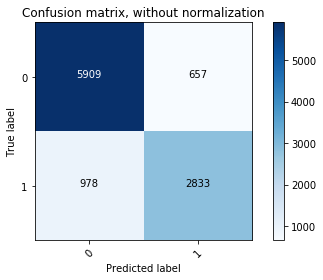

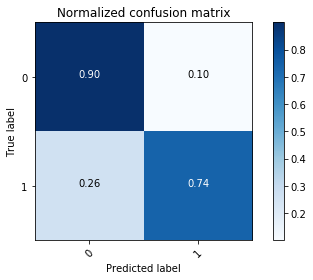

In [59]:
class_names = np.unique(y)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CM, classes=class_names,
                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(CM, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Predicting Block Groups that are likely to get funded in the future

In [62]:
no_enough_funded = data.iloc[np.where(y==0)].copy()

X_pred = no_enough_funded.drop(columns=['int_avail_per', 'block_group', target_col])
proba = grid_search.predict_proba(X_pred)
no_enough_funded['proba'] = proba[:, 1]

In [64]:
no_enough_funded.sort_values('proba', ascending=False)[['block_group', 'proba']].head(10)

,block_group,proba
62731,290659602001,0.990779
42653,121130101002,0.989870
60711,290854701003,0.989494
62241,510230401004,0.984563
63185,221159501006,0.981825
49924,050719517002,0.978432
7814,400770872001,0.973015
28553,191379604001,0.964478
62021,292154803003,0.955416
24909,171759515003,0.952901
